<a href="https://colab.research.google.com/github/bernhardtandy/ProjectsMLAI/blob/main/HW3_AndyBernhardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projects in Machine Learning and AI Homework 3**
## *Two-Layer Neural Network for League of Legends Game Result Prediction*
##### **Andy Bernhardt**
##### **bernha@rpi.edu**

---
## **Task 0: Problem Statement**

League of Legends is a free-to-play multiplayer online battle arena (MOBA) real-time strategy (RTS) video game released in 2009 by Riot Games. With over 100 million monthly active players around the globe, League is one of the most popular competitive online games, and, as such, is at the forefront of Esports: professional competitive video gaming.

In order to describe the goal of the project, we first provide a short introduction to the gameplay of League of Legends. Our description here notes only key aspects of the game, but more information can be found at https://na.leagueoflegends.com/en-us/how-to-play/. 

League of Legends is a team-based strategy game, in which two teams of five players (the blue team and the red team) battle to defend their own base and also attack the enemy base. One team wins when they destroy the opposing team's Nexus, a structure within the opposing team's base. In each game, which typically lasts for 15 to 55 minutes, each of the ten players controls a character, known as a "champion", with unique abilities, strengths, weaknesses, and styles of play. As the game progresses, the players' champions become stronger by accumulating experience points, obtaining gold to buy items, or slaying the neutral monsters on the map (known as objectives). With stronger champions than the opposing team, a team is more likely to win battles against the enemy team and can also easier attack the enemy base; as a result, to win the game, it is advantageous to get an early lead in experience points, gold, and objectives. However, even with an early advantage against the opposing team, victory is not guaranteed, as the opposing team can still fight back.

In this project, we will use a dataset with in-game stats collected at the 15 minute mark of high ranked (top 0.01% of players) games, labeled with the game outcome, and use TensorFlow to implement a two-layer neural network to predict the game outcome. We will focus on how we tune the hyperparameters for this model, and additionally compare the results from a two-layer neural network to another baseline model. 


---
## **Task 1: Researching TensorFlow**

I will be implementing this project using TensorFlow. Below are some links to resources that have been useful for this project:

- https://www.tensorflow.org/tutorials/keras/classification - provides a comprehensive tutorial for implementing a classification model with TensorFlow keras
- https://www.tensorflow.org/api_docs/python/tf/keras/losses - provides a starting point for learning about different loss functions provided in keras
  - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy - information about binary cross-entropy loss for binary classification, which we will use in this project for training
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers - provides a starting point for learning about different optimizers provided in keras
  - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam - information about Adam optimizer for gradient descent, which we will use in the project for training the neural network
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics - provides a starting point for learning about different metrics provided in keras
  - https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy - information about accuracy metric, which we will use in this project for early stopping and also evaluation
- https://keras.io/api/layers/activations/ - information about activation functions, such as 'relu' and 'sigmoid'
- https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/ - a helpful tutorial for binary classification using keras
- https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - a helpful tutorial for visualizing keras models (in this project, we use model.summary())
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ - a helpful tutorial for using grid search to tune hyperparameters
- https://keras.io/api/callbacks/early_stopping/ - information about the keras early stoppping callback, which we will use in this project to alleviate overfitting


---
## **Task 2: Two-Layer Neural Network for League of Legends Game Result Prediction**

In this section, we will do the following:
- Load the required libraries for the project and use GPU
- Load and describe the dataset and split into train, validation, and testing sets
- Perform exploratory data analysis on the dataset
- Preprocess the dataset
- Implement and train a two-layer neural network to solve League of Legends game result prediction using the training and validation sets
- Evaluate the performance of the two-layer neural network on the testing set

### Setup

In [26]:
# Import required libraries for project
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Load dataset from Google Drive

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Add HW3 folder to path
import sys
sys.path.append('/content/drive/MyDrive/ProjectsMLAI/HW3')

In [5]:
# Load League of Legends games dataset
df = pd.read_csv("/content/drive/MyDrive/ProjectsMLAI/HW3/Games.csv")
df = df.rename(columns={"blueDragnoType": "blueDragonType", "redDragnoType": "redDragonType"})
pd.set_option('display.max_columns', None)

### Dataset description

This League of Legends Challenger Ranked Games dataset (from Kaggle), includes two CSV files: one with in-game stats collected from Challenger (top 0.01% of players) ranked games at the 10 minute mark, and a second with in-game stats collected from Challenger ranked games at the 15 minute mark. The data includes, for both the blue and red teams: gold, level (experience), minion kills, champion kills, deaths, and assists, wards (vision), tower, and dragon/rift herald (neutral objective) stats, and each game is labeled with a 0 (denoting that the red team eventually won) or a 1 (denoting the the blue team eventually won).

In this project, we explore the data from the 15-minute-mark dataset, and use it to train and test models for (binary) game result prediction. We first split the dataset 70/20/10 into training, validation, and test sets, next explore and analyze the training data, and then implement a two-layer neural network to train a model to predict the game outcome the feature information. During training, we use the validation set for early stopping (to alleviate overfitting), and also to tune hyperparameters. This model is finally evaluated on the held-out test set, and compared to an alternative baseline model.  

Link to dataset: https://www.kaggle.com/datasets/gyejr95/league-of-legends-challenger-rank-game10min15min

### Split data into training, validation, and testing sets

In [6]:
df

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragonType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragonType,redDragon,redRiftHeralds
0,4247263043,0,24081,1190,44,8.8,309,74,0,8,14,14,29,8,0,0,[],0,0,0,0,0,0,[],0,0,1,30099,6073,48,9.6,366,76,0,14,8,34,31,12,1,0,['MID_LANE'],2,1,0,1,0,1,"['WATER_DRAGON', 'EARTH_DRAGON']",2,1
1,4247155821,1,24162,2212,46,9.2,393,64,0,5,6,5,31,6,0,0,[],0,0,0,0,0,0,[],0,1,0,26015,3900,48,9.6,394,89,0,6,5,5,26,11,1,0,['TOP_LANE'],1,0,1,0,0,0,[],0,0
2,4243963257,0,22413,1563,41,8.2,300,62,0,5,20,8,28,7,0,0,[],0,0,0,0,0,0,[],0,0,1,34296,5496,50,10.0,388,85,0,20,5,20,39,9,1,0,['BOT_LANE'],4,2,1,1,0,1,"['FIRE_DRAGON', 'EARTH_DRAGON']",2,1
3,4241678498,0,23837,3197,46,9.2,370,96,0,6,13,9,108,9,0,0,[],0,0,0,0,0,1,['AIR_DRAGON'],1,0,1,27824,5223,48,9.6,405,72,0,13,6,24,26,13,1,0,['TOP_LANE'],1,0,1,0,0,0,[],0,1
4,4241538868,1,27688,3663,44,8.8,381,66,0,9,10,10,36,11,0,0,[],1,0,1,0,0,1,['WATER_DRAGON'],1,1,0,25826,2909,47,9.4,329,87,0,10,9,17,41,9,1,0,['BOT_LANE'],2,1,0,1,0,0,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26829,4143231833,0,26110,1535,46,9.2,289,73,0,15,14,25,38,9,0,0,[],0,0,0,0,0,0,['EARTH_DRAGON'],1,0,1,27301,3931,47,9.4,323,84,0,14,15,17,30,11,1,0,['BOT_LANE'],1,0,0,1,0,1,['WATER_DRAGON'],1,1
26830,4157911901,0,57503,3293,62,12.4,329,28,0,27,37,33,36,2,1,0,['TOP_LANE'],5,3,2,0,1,1,"['WATER_DRAGON', 'AIR_DRAGON', 'FIRE_DRAGON']",3,0,1,62919,6253,64,12.8,428,120,0,37,27,29,41,0,0,1,[],6,2,1,3,1,0,[],0,0
26831,3764171638,0,26091,2986,47,9.4,338,86,0,7,6,8,40,12,1,0,['TOP_LANE'],1,0,1,0,0,0,[],0,0,1,25579,1897,46,9.2,377,88,0,6,7,8,80,8,0,0,[],0,0,0,0,0,0,[],0,0
26832,4110201724,1,24734,4289,45,9.0,328,64,0,11,7,20,33,10,0,0,[],0,0,0,0,0,1,['FIRE_DRAGON'],1,0,0,23593,4668,43,8.6,343,67,0,7,11,11,31,13,1,0,['BOT_LANE'],1,0,0,1,0,0,['AIR_DRAGON'],1,0


In [7]:
# Split dataframe into training (70%), validation (20%), and testing (10%) sets
df_train, df_test = train_test_split(df, test_size=0.10, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=2./9., random_state=42)
df_train.shape, df_val.shape, df_test.shape

((18783, 51), (5367, 51), (2684, 51))

### Exploratory Data Analysis

In [73]:
# Show training data
df_train
# The shape of the dataframe is 18783 rows × 51 columns

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragonType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragonType,redDragon,redRiftHeralds
19410,3996141172,1,28524,2262,48,9.6,362,92,0,13,9,14,43,14,1,0,['MID_LANE'],2,1,1,0,0,1,"['FIRE_DRAGON', 'AIR_DRAGON']",2,1,0,25488,2868,47,9.4,378,89,0,9,13,16,32,10,0,0,[],0,0,0,0,0,0,[],0,0
12656,4205846606,1,26439,4142,48,9.6,340,84,0,9,4,15,75,13,1,0,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1,0,22790,3315,45,9.0,370,83,0,4,9,3,32,16,0,0,[],0,0,0,0,0,0,['AIR_DRAGON'],1,0
4766,4164709646,1,32112,2519,50,10.0,373,131,0,14,7,12,62,12,1,0,['TOP_LANE'],4,2,1,1,0,1,"['FIRE_DRAGON', 'EARTH_DRAGON']",2,1,0,24231,2333,45,9.0,342,72,0,7,14,8,101,6,0,0,[],1,0,1,0,0,0,[],0,0
21819,4159247589,1,28764,2369,47,9.4,322,81,0,18,8,30,42,12,1,0,['TOP_LANE'],1,0,1,0,0,0,[],0,1,0,23254,2324,44,8.8,318,87,0,8,18,15,28,14,0,0,[],0,0,0,0,0,1,"['EARTH_DRAGON', 'WATER_DRAGON']",2,0
9864,4174126907,0,22209,3634,44,8.8,287,71,0,6,18,7,34,9,0,0,[],0,0,0,0,0,0,[],0,0,1,30919,3654,48,9.6,363,106,0,18,6,24,70,8,1,0,['TOP_LANE'],2,1,1,0,0,1,"['AIR_DRAGON', 'FIRE_DRAGON']",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17826,4144981112,1,25650,4080,41,8.2,286,69,0,15,0,21,16,2,1,1,['BOT_LANE'],6,5,0,1,1,1,['EARTH_DRAGON'],1,1,0,12605,2367,29,5.8,157,36,0,0,15,0,23,3,0,0,[],0,0,0,0,0,0,[],0,0
25871,4174667783,0,25891,4046,45,9.0,363,61,0,11,20,12,36,11,0,0,[],0,0,0,0,0,0,[],0,0,1,31300,610,50,10.0,389,73,0,20,11,23,44,15,1,0,['BOT_LANE'],2,0,1,1,0,1,"['FIRE_DRAGON', 'WATER_DRAGON']",2,0
17108,4179853282,0,16182,1462,33,6.6,223,46,0,2,9,1,15,9,0,0,[],0,0,0,0,0,0,[],0,0,1,25971,5388,45,9.0,360,81,0,9,2,15,50,5,1,1,['MID_LANE'],5,5,0,0,1,1,['FIRE_DRAGON'],1,1
20731,4081629001,1,27069,3329,46,9.2,400,63,0,11,6,11,38,7,1,0,['MID_LANE'],1,1,0,0,0,1,['WATER_DRAGON'],1,0,0,21879,2554,42,8.4,335,71,0,6,11,7,41,8,0,0,[],0,0,0,0,0,0,[],0,0


In [52]:
# Show label distribution of df_train
print(f"Value counts:\n{df_train.blueWins.value_counts()}")
# The training data is approximately balanced

Value counts:
1    9403
0    9380
Name: blueWins, dtype: int64


In [53]:
# Show column information
df_train.info()
# Most of the features are numerical, but some are categorical or lists (object)
# For each team (blue or red), the meaning of the column is as follows:
  # wins: categorical variable: 0 denotes that the team eventually lost the game, 1 denotes that the team eventually won the game (target label)
  # total gold: integer value with the team's accumulated gold at 15 minutes
  # current gold: integer value with the team's current unspent gold at 15 minutes
  # total level: integer value with the team's accumulated level at 15 minutes
  # avg level: float value with the team's average level at 15 minutes: total level / 5 (this feature is perfectly correlated with total level, so we will drop it)
  # total minion kills: integer value with the team's total lane minion kills at 15 minutes
  # total jungle minion kills: integer value with the team's total jungle minion kills at 15 minutes
  # first blood: categorical variable: 0 denotes that the team did not get the first champion kill, 1 denotes that the team got the first champion kill
    # Note: this can be 0 for both teams, in the event that no teams get a champion kill within 15 minutes, but cannot be 1 for both teams simultaneously
  # kill: integer value with the team's total champion kills at 15 minutes
  # death: integer value with the team's total deaths at 15 minutes
  # assist: integer value with the team's total assists at 15 minutes
  # ward placed: integer value with the team's total wards placed at 15 minutes
  # ward kills: integer value with the team's total wards killed at 15 minutes
  # first tower: categorical variable: 0 denotes that the team did not get the first tower, 1 denotes that the team got the first tower
    # Note: this can be 0 for both teams, in the event that no teams get a tower within 15 minutes, but cannot be 1 for both teams simultaneously
  # first inhibitor: categorical variable: 0 denotes that the team did not get the first inhibitor, 1 denotes that the team got the first inhibitor
    # Note: this can be 0 for both teams, in the event that no teams get an inhibitor within 15 minutes, but cannot be 1 for both teams simultaneously
  # first tower lane: categorical variable: empty list denotes that the team did not get the first tower, otherwise, either ['TOP_LANE'], ['MID_LANE'], or ['BOT_LANE'], the lane in which the first tower was achieved
  # tower kills: integer value with the team's number of towers destroyed at 15 minutes
  # mid tower kills: integer value with the team's number of towers destroyed in mid lane at 15 minutes
  # top tower kills: integer value with the team's number of towers destroyed in top lane at 15 minutes
  # bot tower kills: integer value with the team's number of towers destroyed in bot lane at 15 minutes
  # inhibitor: integer value with the team's number of inhibitors destroyed at 15 minutes
  # first dragon: categorical variable: 0 denotes that the team did not kill the first dragon, 1 denotes that the team killed the first dragon
    # Note: this can be 0 for both teams, in the event that no teams kill a dragon within 15 minutes, but cannot be 1 for both teams simultaneously
  # dragon type: categorical variable: empty list denotes that the team did not kill any dragons, otherwise, a list containing at most two (unique) of 'AIR_DRAGON', 'EARTH_DRAGON', 'WATER_DRAGON', and 'FIRE_DRAGON'
  # dragon: integer value with the team's total number of dragon kills at 15 minutes
  # rift heralds: integer value with the team's total number of rift herald kils at 15 minutes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18783 entries, 19410 to 23411
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   gameId                      18783 non-null  int64   
 1   blueWins                    18783 non-null  category
 2   blueTotalGolds              18783 non-null  int64   
 3   blueCurrentGolds            18783 non-null  int64   
 4   blueTotalLevel              18783 non-null  int64   
 5   blueAvgLevel                18783 non-null  float64 
 6   blueTotalMinionKills        18783 non-null  int64   
 7   blueTotalJungleMinionKills  18783 non-null  int64   
 8   blueFirstBlood              18783 non-null  int64   
 9   blueKill                    18783 non-null  int64   
 10  blueDeath                   18783 non-null  int64   
 11  blueAssist                  18783 non-null  int64   
 12  blueWardPlaced              18783 non-null  int64   
 13  blueWardKill

In [54]:
# Show dataset statistics for numerical columns (including already one-hot encoded categorical variables)
df_train.describe()
# Note: there is some noisy data: for example, in one row the blue current gold is -4289, this is not possible...
# Additionally, blue and red first blood are empty: we will drop these columns later as they provide no information

,gameId,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragon,redRiftHeralds
count,1.878300e+04,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.0,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.00000,18783.000000,18783.0,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000,18783.000000
mean,4.171528e+09,28491.861577,3475.361284,47.722196,9.544439,331.464729,71.526380,0.0,13.160464,13.191450,18.740617,37.904115,8.919821,0.392749,0.042059,0.972635,0.372358,0.316829,0.283448,0.049992,0.397221,0.650695,0.456636,0.499388,28419.500399,3458.313422,47.812756,9.562551,333.04190,73.044562,0.0,13.191450,13.160464,18.720865,43.674546,8.623543,0.520364,0.054784,1.339722,0.481925,0.411489,0.446308,0.065325,0.499760,0.790928,0.331151
std,7.605348e+07,7899.677851,1571.786890,8.524478,1.704896,70.222908,26.583563,0.0,8.988363,8.966423,19.475229,27.070077,4.942914,0.488375,0.200730,1.262188,0.805480,0.551353,0.511341,0.242671,0.489335,0.728915,0.502068,0.500013,7892.230675,1577.886436,8.484775,1.696955,70.24716,27.001193,0.0,8.966423,8.988363,19.426496,31.668467,4.813579,0.499598,0.227563,1.396354,0.924461,0.593715,0.588626,0.274075,0.500013,0.749684,0.473009
min,3.482868e+09,3627.000000,-4289.000000,5.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3215.000000,-3822.000000,5.000000,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.141752e+09,24759.500000,2376.000000,45.000000,9.000000,316.000000,64.000000,0.0,8.000000,8.000000,9.000000,28.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24729.000000,2338.500000,45.000000,9.000000,319.00000,65.000000,0.0,8.000000,8.000000,9.000000,28.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.190700e+09,26820.000000,3205.000000,46.000000,9.200000,349.000000,76.000000,0.0,11.000000,11.000000,14.000000,33.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26736.000000,3192.000000,46.000000,9.200000,350.00000,78.000000,0.0,11.000000,11.000000,14.000000,34.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.219768e+09,29469.500000,4291.000000,48.000000,9.600000,374.000000,87.000000,0.0,15.000000,16.000000,20.000000,41.000000,12.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,29341.500000,4274.000000,48.000000,9.600000,375.00000,89.000000,0.0,16.000000,15.000000,20.000000,50.000000,11.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,4.261013e+09,80503.000000,16905.000000,80.000000,16.000000,463.000000,206.000000,0.0,92.000000,88.000000,165

In [55]:
# Show dataset statistics for categorical columns
df_train.describe(include=['O'])
# Blue dragon type and red dragon type should have at most 11 values (4 choose 2 + 4 choose 1 + 4 choose 0), this is suspicious...

,blueFirstTowerLane,blueDragonType,redFirstTowerLane,redDragonType
count,18783,18783,18783,18783
unique,4,48,4,41
top,[],[],[],[]
freq,11406,9366,9009,7616


In [56]:
# Look at blue dragon type value counts
df_train.blueDragonType.value_counts()
# At the 15 minute mark, each team can only possible kill at most two dragons
# Additionally, the elder dragon does not spawn until after at least four dragons have been killed
# As a result, this column seems to contain very noisy data, and so we will not use blue dragon type or red dragon type as features for our model 

[]                                                                 9366
['EARTH_DRAGON']                                                   1735
['AIR_DRAGON']                                                     1708
['FIRE_DRAGON']                                                    1642
['WATER_DRAGON']                                                   1570
['FIRE_DRAGON', 'EARTH_DRAGON']                                     258
['FIRE_DRAGON', 'AIR_DRAGON']                                       251
['WATER_DRAGON', 'AIR_DRAGON']                                      250
['FIRE_DRAGON', 'WATER_DRAGON']                                     250
['WATER_DRAGON', 'EARTH_DRAGON']                                    243
['WATER_DRAGON', 'FIRE_DRAGON']                                     237
['AIR_DRAGON', 'FIRE_DRAGON']                                       226
['EARTH_DRAGON', 'FIRE_DRAGON']                                     216
['EARTH_DRAGON', 'WATER_DRAGON']                                

In [57]:
# Check for missing values
df_train.isna().sum()
# All of the fields of all of the rows are populated; there are no missing values

gameId                        0
blueWins                      0
blueTotalGolds                0
blueCurrentGolds              0
blueTotalLevel                0
blueAvgLevel                  0
blueTotalMinionKills          0
blueTotalJungleMinionKills    0
blueFirstBlood                0
blueKill                      0
blueDeath                     0
blueAssist                    0
blueWardPlaced                0
blueWardKills                 0
blueFirstTower                0
blueFirstInhibitor            0
blueFirstTowerLane            0
blueTowerKills                0
blueMidTowerKills             0
blueTopTowerKills             0
blueBotTowerKills             0
blueInhibitor                 0
blueFirstDragon               0
blueDragonType                0
blueDragon                    0
blueRiftHeralds               0
redWins                       0
redTotalGolds                 0
redCurrentGolds               0
redTotalLevel                 0
redAvgLevel                   0
redTotal

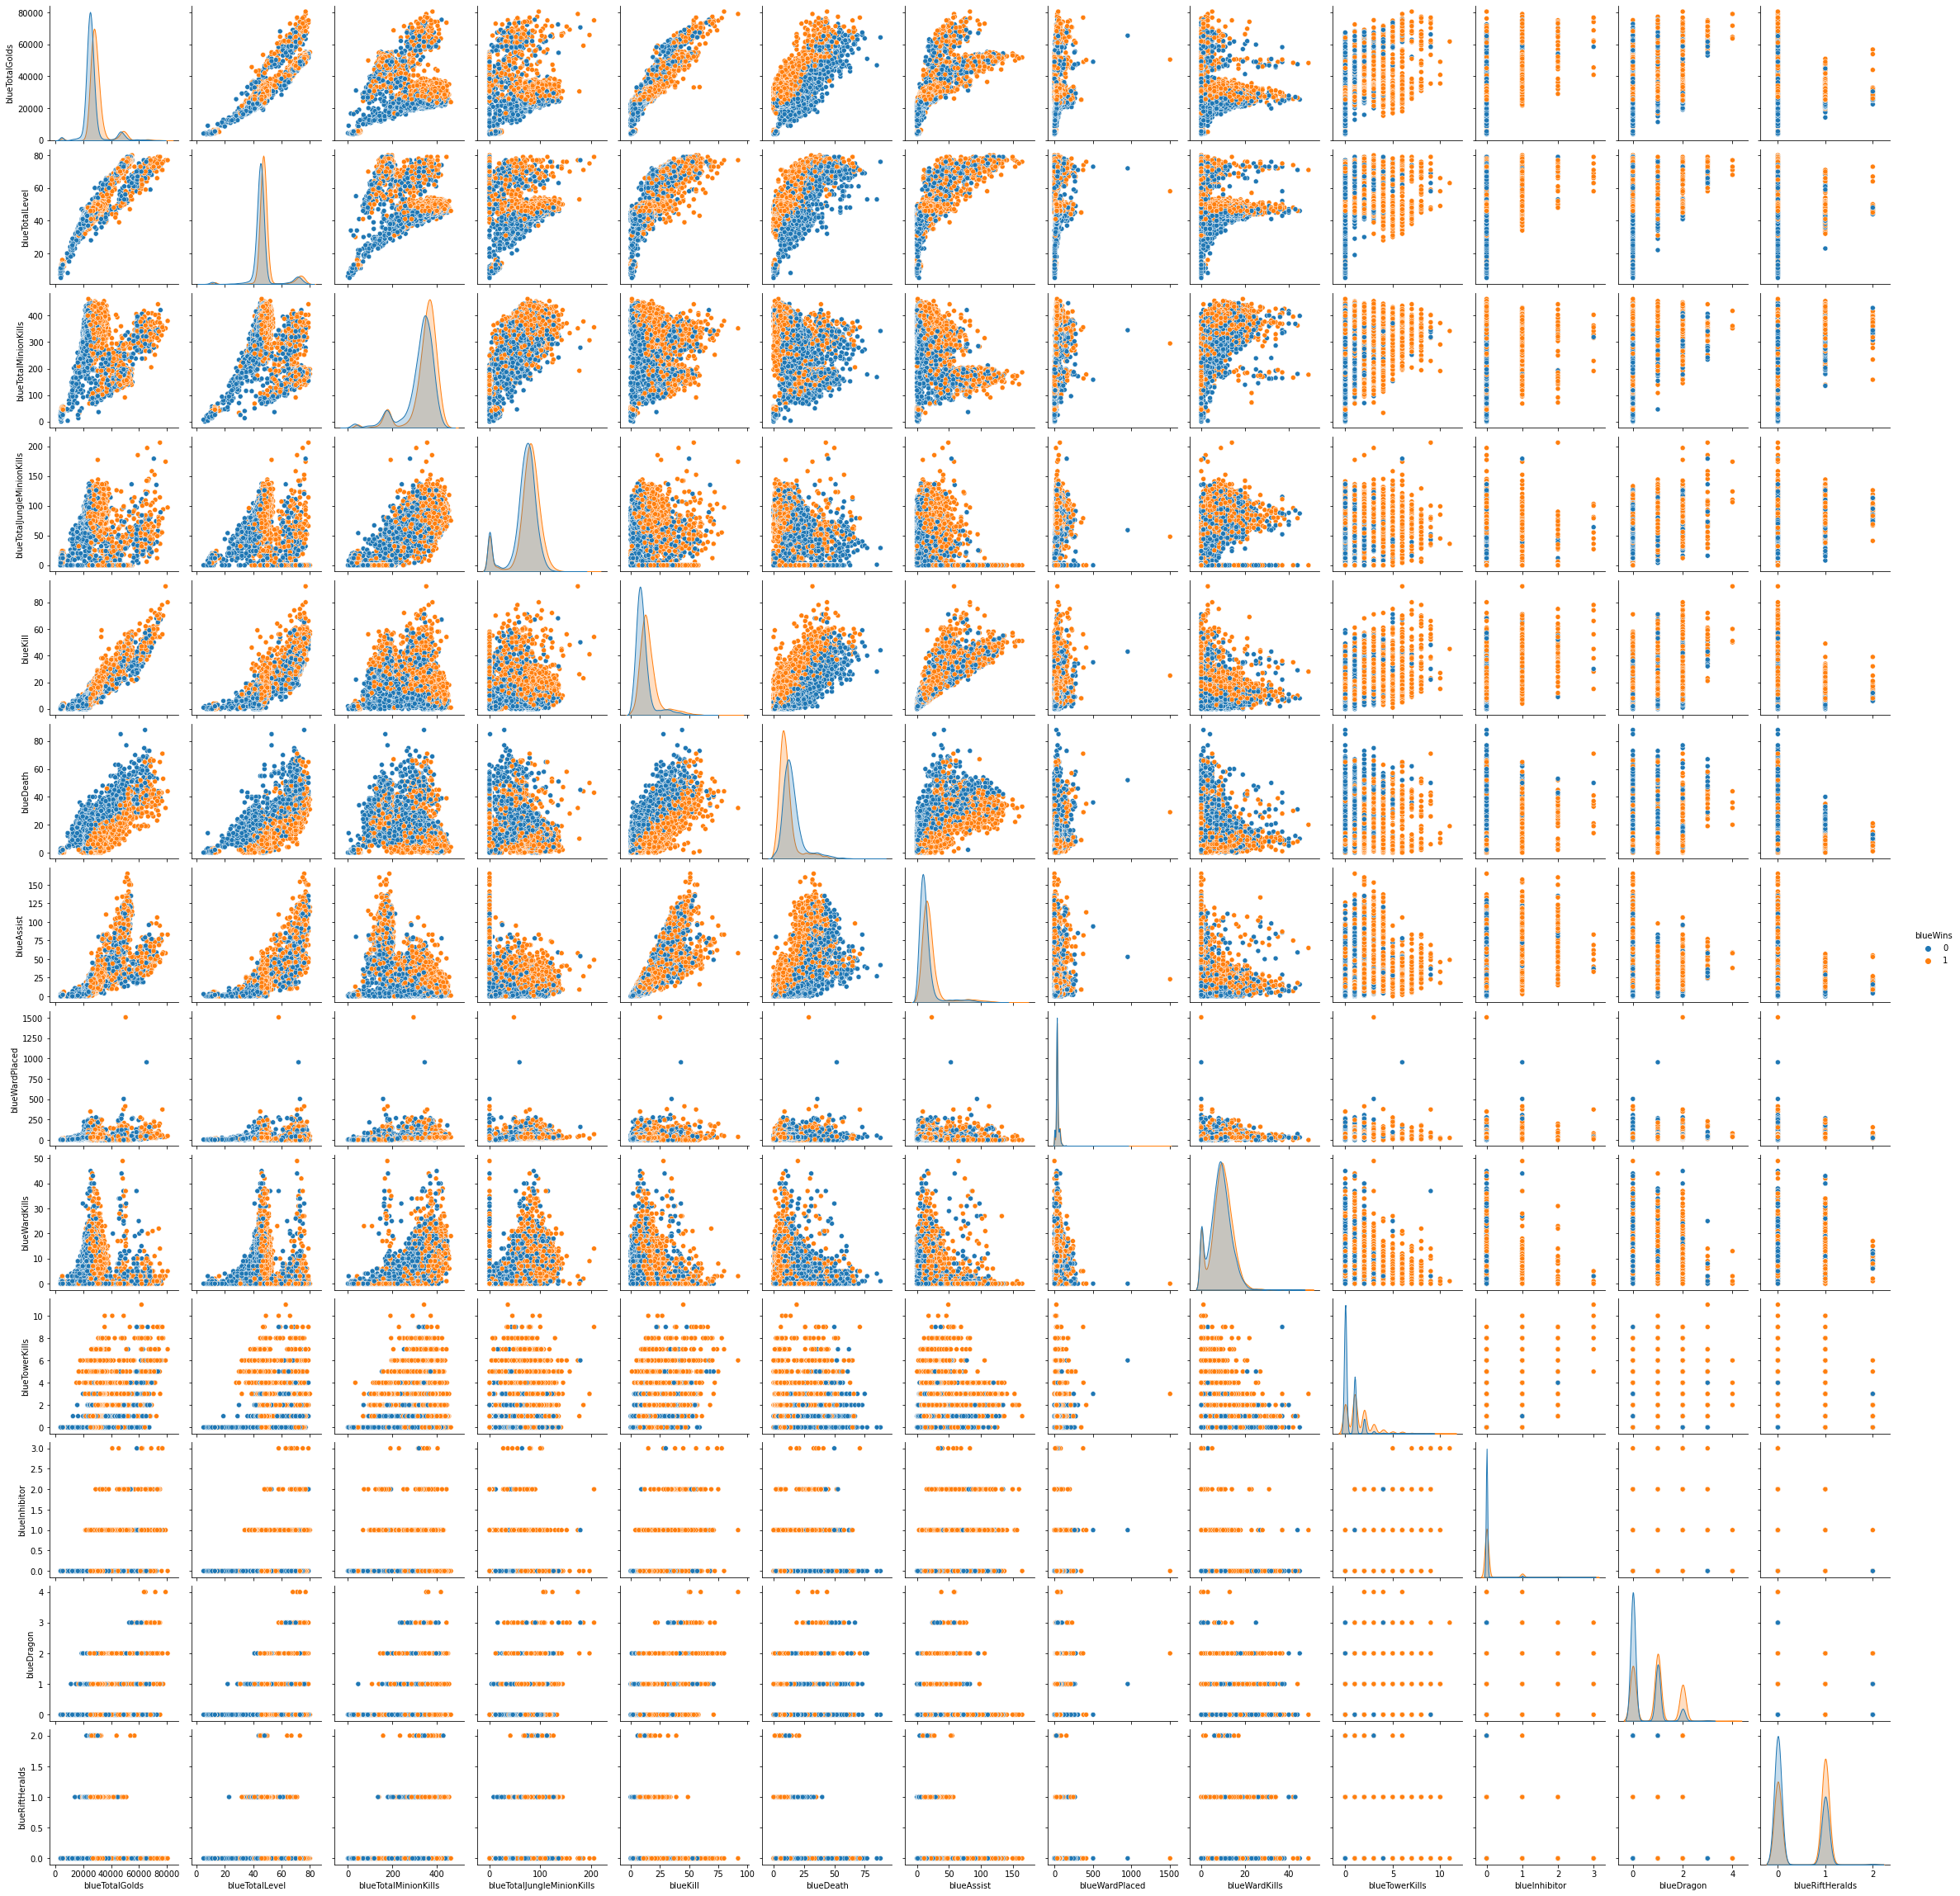

In [63]:
# Plot pairwise relationships between numerical features (blue team only) in the dataset (this should be similar for red team, since the game is symmetric)
sns.pairplot(df_train[['blueWins', 'blueTotalGolds', 'blueTotalLevel', 'blueTotalMinionKills', 'blueTotalJungleMinionKills', 
                       'blueKill', 'blueDeath', 'blueAssist', 'blueWardPlaced', 'blueWardKills',  'blueTowerKills', 
                       'blueInhibitor', 'blueDragon', 'blueRiftHeralds']], hue='blueWins')
# Note: we do not produce a pairplot for all features since this would be too large
# Here, we see that total gold and total level have a strong relationship, as well as total gold and number of kills
# Tower kills and dragon kills seem to be a good predictor of the game outcome, as well as the ratio between kills and deaths

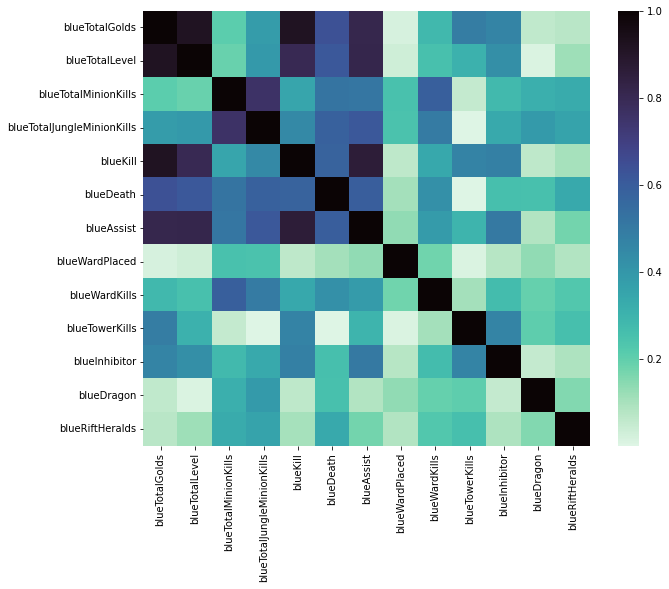

In [64]:
# Investigate pairwise feature correlation (within one team)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_train[['blueWins', 'blueTotalGolds', 'blueTotalLevel', 'blueTotalMinionKills', 'blueTotalJungleMinionKills', 
                       'blueKill', 'blueDeath', 'blueAssist', 'blueWardPlaced', 'blueWardKills',  'blueTowerKills', 
                       'blueInhibitor', 'blueDragon', 'blueRiftHeralds']].corr().abs(), annot=False, ax=ax, cmap='mako_r')
# Again, we see that total gold, total level, kills, and assists are strongly correlated (you get gold and experience from kills and assists in game)
# Other pairs of variables have weak to moderate relationships

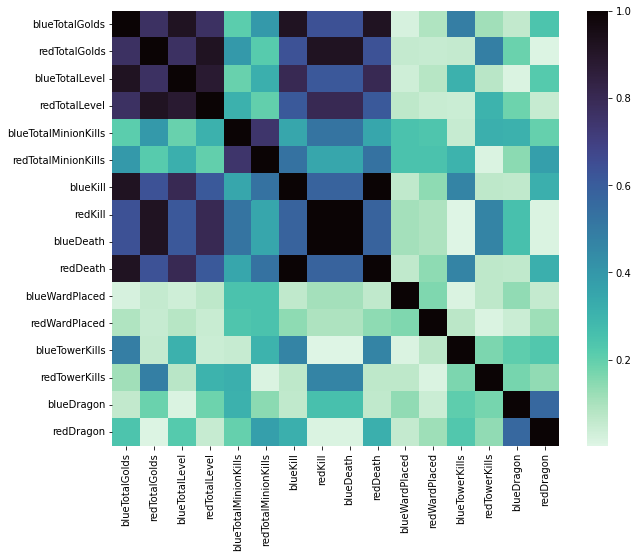

In [66]:
# Investigate pairwise feature correlation (across teams)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_train[['blueTotalGolds', 'redTotalGolds', 'blueTotalLevel', 'redTotalLevel', 'blueTotalMinionKills', 'redTotalMinionKills', 
                       'blueKill', 'redKill', 'blueDeath', 'redDeath', 'blueWardPlaced', 'redWardPlaced',  'blueTowerKills', 
                       'redTowerKills', 'blueDragon', 'redDragon']].corr().abs(), annot=False, ax=ax, cmap='mako_r')
# Blue kill and red death are perfectly correlated, and red kill and blue death are perfectly correlated; we will drop red kill and red death from features as they do not provide any more information
# Total gold between teams are strongly correlated (presumably negative) and additionally are strongly correlated with kills and deaths for both teams
# Blue dragon kills and red dragon kills have a moderate correlation (presumably negative)

In [69]:
df_train.columns

Index(['gameId', 'blueWins', 'blueTotalGolds', 'blueCurrentGolds',
       'blueTotalLevel', 'blueAvgLevel', 'blueTotalMinionKills',
       'blueTotalJungleMinionKills', 'blueFirstBlood', 'blueKill', 'blueDeath',
       'blueAssist', 'blueWardPlaced', 'blueWardKills', 'blueFirstTower',
       'blueFirstInhibitor', 'blueFirstTowerLane', 'blueTowerKills',
       'blueMidTowerKills', 'blueTopTowerKills', 'blueBotTowerKills',
       'blueInhibitor', 'blueFirstDragon', 'blueDragonType', 'blueDragon',
       'blueRiftHeralds', 'redWins', 'redTotalGolds', 'redCurrentGolds',
       'redTotalLevel', 'redAvgLevel', 'redTotalMinionKills',
       'redTotalJungleMinionKills', 'redFirstBlood', 'redKill', 'redDeath',
       'redAssist', 'redWardPlaced', 'redWardKills', 'redFirstTower',
       'redFirstInhibitor', 'redFirstTowerLane', 'redTowerKills',
       'redMidTowerKills', 'redTopTowerKills', 'redBotTowerKills',
       'redInhibitor', 'redFirstDragon', 'redDragonType', 'redDragon',
       'redRift

In [74]:
# Show feature correlations (Pearson) with target variable in decreasing order
df_train.corr()['blueWins'].sort_values(ascending=False)
# Here, we see that none of our features have a particularly strong linear relationship with the target variable

blueWins                      1.000000
blueTowerKills                0.378986
blueFirstTower                0.347760
blueDragon                    0.326279
blueMidTowerKills             0.277973
blueKill                      0.277711
redDeath                      0.277711
blueBotTowerKills             0.275449
blueCurrentGolds              0.262060
blueFirstDragon               0.258718
blueTotalGolds                0.225905
blueRiftHeralds               0.214261
blueTopTowerKills             0.206041
blueAssist                    0.177002
blueTotalMinionKills          0.165568
blueTotalLevel                0.159667
blueAvgLevel                  0.159667
blueFirstInhibitor            0.158355
blueInhibitor                 0.148718
blueTotalJungleMinionKills    0.142015
blueWardKills                 0.077896
blueWardPlaced                0.038532
gameId                       -0.004185
redWardPlaced                -0.049332
redWardKills                 -0.073712
redInhibitor             

In [75]:
# Show feature correlations (Spearman) with target variable in decreasing order
df_train.corr(method='spearman')['blueWins'].sort_values(ascending=False)
# Here, we see that some of the features (total gold, total level, tower kills, kills, dragons) have a moderate noniinear relationship to the target variable

blueWins                      1.000000
blueTotalGolds                0.472009
blueTotalLevel                0.415788
blueAvgLevel                  0.415788
blueTowerKills                0.413694
blueKill                      0.395896
redDeath                      0.395896
blueFirstTower                0.347760
blueAssist                    0.346132
blueDragon                    0.327738
blueMidTowerKills             0.298317
blueBotTowerKills             0.284390
blueFirstDragon               0.258718
blueCurrentGolds              0.253533
blueTotalMinionKills          0.235497
blueRiftHeralds               0.215026
blueTopTowerKills             0.208969
blueTotalJungleMinionKills    0.203463
blueFirstInhibitor            0.158355
blueInhibitor                 0.154523
blueWardKills                 0.088351
blueWardPlaced                0.072812
gameId                       -0.013961
redWardPlaced                -0.065250
redWardKills                 -0.080234
redInhibitor             

### Data preprocessing
- Drop columns we do not want to use and isolate features
- Normalize features
- Isolate labels

In [8]:
# Drop the features that we do not want to keep for our model: 'gameId', 'blueFirstBlood', 'redFirstBlood', 'blueDragonType', 'redDragonType', 
# 'redWins', 'redKill', 'redDeath', 'blueAvgLevel', 'redAvgLevel', 'blueFirstTowerLane', 'redFirstTowerLane'
# Isolate features
X_train = df_train.drop(['blueWins', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'blueDragonType', 'redDragonType', 'redWins', 'redKill', 'redDeath', 'blueAvgLevel', 'redAvgLevel', 'blueFirstTowerLane', 'redFirstTowerLane'], axis=1)
X_val = df_val.drop(['blueWins', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'blueDragonType', 'redDragonType', 'redWins', 'redKill', 'redDeath', 'blueAvgLevel', 'redAvgLevel', 'blueFirstTowerLane', 'redFirstTowerLane'], axis=1)
X_test = df_test.drop(['blueWins', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'blueDragonType', 'redDragonType', 'redWins', 'redKill', 'redDeath', 'blueAvgLevel', 'redAvgLevel', 'blueFirstTowerLane', 'redFirstTowerLane'], axis=1)
X_train.shape, X_val.shape, X_test.shape
# We check that our feature matrices have the correct shape

((18783, 38), (5367, 38), (2684, 38))

In [9]:
# Normalize features
transformer = Normalizer(norm='max').fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)
# Puts all independent variables on the same scale

In [10]:
# Isolate labels
y_train = df_train.blueWins
y_val = df_val.blueWins
y_test = df_test.blueWins
y_train.shape, y_val.shape, y_test.shape
# We check that our label vectors have the correct shape

((18783,), (5367,), (2684,))

### Two-Layer Neural Network Implementation 

In [11]:
def createTwoLayerNN(name, layer_1, layer_2):
    input = tf.keras.layers.Input(shape=(38), name='input', dtype='float64')

    X = tf.keras.layers.Dense(layer_1, name='hidden_layer_1', activation='relu')(input)
    X = tf.keras.layers.Dense(layer_2, name='hidden_layer_2', activation='relu')(X)
    output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(X)

    model = tf.keras.Model(name=name, inputs=input, outputs=output)

    return model

In [12]:
def train(hyperparameters, X_train, y_train, X_val, y_val):
  layer1 = hyperparameters[0]
  layer2 = hyperparameters[1]
  lr = hyperparameters[2]
  batch_size = hyperparameters[3]
  model = createTwoLayerNN("2NN", layer1, layer2)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True)
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
  history = model.fit(x=X_train, y=y_train, epochs=1000, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], verbose=2)
  return model, history

In [13]:
def evaluate(model, features, labels):
    predictions = model.predict(features)
    predictions = [1 if p >= 0.5 else 0 for p in predictions]
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    p = precision_score(labels, predictions)
    r = recall_score(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    cr = classification_report(labels, predictions, target_names=['red win', 'blue win'])
    return acc, f1, p, r, cm, cr

In [14]:
def trainAndEvaluate(hyperparameters, X_train, y_train, X_val, y_val):
  model, history = train(hyperparameters, X_train, y_train, X_val, y_val)
  acc, f1, p, r, cm, cr = evaluate(model, X_val, y_val)
  return model, history, acc, f1, p, r, cm, cr

In [15]:
def varyHyperparameters(hyperparameters, X_train, y_train, X_val, y_val):
  best_val_accuracy = 0.
  best_model = None
  best_history = None
  results_dict = {}
  i = 0
  for h in hyperparameters:
    print(f"Hyperparameters: {h}")
    mod, hist, acc, f1, p, r, cm, cr = trainAndEvaluate(h, X_train, y_train, X_val, y_val)
    results_dict[i] = mod, hist, acc, f1, p, r, cm, cr
    if (acc > best_val_accuracy):
      best_val_accuracy = acc
      best_model = mod
      best_history = hist
    print("\n")
    i += 1
  return best_model, best_history, results_dict

In [16]:
def plotHistory(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel("Epoch Number")
  plt.ylabel("Binary Cross-Entropy Loss")
  plt.title("Binary Cross-Entropy Loss vs. Epoch Number")
  plt.legend(["Training Loss", "Validation Loss"])
  plt.grid()
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel("Epoch Number")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs. Epoch Number")
  plt.legend(["Training Accuracy", "Validation Accuracy"])
  plt.grid()
  plt.show()

In [17]:
# Tunable parameters:
  # Layer 1 size
  # Layer 2 size
  # Initial learning rate
  # Minibatch size

In [32]:
layer_1 = [10, 50, 100, 200]
layer_2 = [10, 20, 50]
lr = [1e-5, 1e-3, 1e-1]
batch_size = [128]
hyperparameters = []
for l1 in layer_1:
  for l2 in layer_2:
    for l in lr:
      for b in batch_size:
        hyperparameters.append([l1, l2, l, b])

In [33]:
best_model, best_history, results_dict = varyHyperparameters(hyperparameters, X_train, y_train, X_val, y_val)

Hyperparameters: [10, 10, 1e-05, 128]
Epoch 1/1000
147/147 - 1s - loss: 0.6869 - accuracy: 0.5110 - val_loss: 0.6866 - val_accuracy: 0.5077 - 1s/epoch - 7ms/step
Epoch 2/1000
147/147 - 0s - loss: 0.6861 - accuracy: 0.5654 - val_loss: 0.6858 - val_accuracy: 0.6091 - 490ms/epoch - 3ms/step
Epoch 3/1000
147/147 - 0s - loss: 0.6853 - accuracy: 0.6413 - val_loss: 0.6851 - val_accuracy: 0.6508 - 426ms/epoch - 3ms/step
Epoch 4/1000
147/147 - 0s - loss: 0.6845 - accuracy: 0.6760 - val_loss: 0.6843 - val_accuracy: 0.6696 - 411ms/epoch - 3ms/step
Epoch 5/1000
147/147 - 0s - loss: 0.6837 - accuracy: 0.6867 - val_loss: 0.6835 - val_accuracy: 0.6842 - 428ms/epoch - 3ms/step
Epoch 6/1000
147/147 - 0s - loss: 0.6828 - accuracy: 0.6974 - val_loss: 0.6827 - val_accuracy: 0.6985 - 493ms/epoch - 3ms/step
Epoch 7/1000
147/147 - 0s - loss: 0.6820 - accuracy: 0.7133 - val_loss: 0.6819 - val_accuracy: 0.7147 - 423ms/epoch - 3ms/step
Epoch 8/1000
147/147 - 0s - loss: 0.6812 - accuracy: 0.7268 - val_loss: 0.68

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

147/147 - 1s - loss: 0.6593 - accuracy: 0.7124 - val_loss: 0.6094 - val_accuracy: 0.7649 - 998ms/epoch - 7ms/step
Epoch 2/1000
147/147 - 0s - loss: 0.5441 - accuracy: 0.7784 - val_loss: 0.4900 - val_accuracy: 0.7831 - 421ms/epoch - 3ms/step
Epoch 3/1000
147/147 - 0s - loss: 0.4657 - accuracy: 0.7868 - val_loss: 0.4514 - val_accuracy: 0.7889 - 486ms/epoch - 3ms/step
Epoch 4/1000
147/147 - 0s - loss: 0.4421 - accuracy: 0.7925 - val_loss: 0.4390 - val_accuracy: 0.7913 - 497ms/epoch - 3ms/step
Epoch 5/1000
147/147 - 0s - loss: 0.4331 - accuracy: 0.7954 - val_loss: 0.4327 - val_accuracy: 0.7917 - 485ms/epoch - 3ms/step
Epoch 6/1000
147/147 - 0s - loss: 0.4287 - accuracy: 0.7976 - val_loss: 0.4301 - val_accuracy: 0.7941 - 421ms/epoch - 3ms/step
Epoch 7/1000
147/147 - 0s - loss: 0.4273 - accuracy: 0.7978 - val_loss: 0.4332 - val_accuracy: 0.7943 - 421ms/epoch - 3ms/step
Epoch 8/1000
147/147 - 0s - loss: 0.4255 - accuracy: 0.8000 - val_loss: 0.4287 - val_accuracy: 0.7958 - 426ms/epoch - 3ms/st

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

147/147 - 1s - loss: 0.6904 - accuracy: 0.5106 - val_loss: 0.6881 - val_accuracy: 0.5763 - 928ms/epoch - 6ms/step
Epoch 2/1000
147/147 - 0s - loss: 0.6863 - accuracy: 0.6347 - val_loss: 0.6846 - val_accuracy: 0.7203 - 424ms/epoch - 3ms/step
Epoch 3/1000
147/147 - 0s - loss: 0.6830 - accuracy: 0.7444 - val_loss: 0.6815 - val_accuracy: 0.7695 - 481ms/epoch - 3ms/step
Epoch 4/1000
147/147 - 0s - loss: 0.6800 - accuracy: 0.7800 - val_loss: 0.6785 - val_accuracy: 0.7813 - 480ms/epoch - 3ms/step
Epoch 5/1000
147/147 - 0s - loss: 0.6770 - accuracy: 0.7863 - val_loss: 0.6757 - val_accuracy: 0.7887 - 486ms/epoch - 3ms/step
Epoch 6/1000
147/147 - 0s - loss: 0.6741 - accuracy: 0.7884 - val_loss: 0.6728 - val_accuracy: 0.7861 - 410ms/epoch - 3ms/step
Epoch 7/1000
147/147 - 0s - loss: 0.6712 - accuracy: 0.7906 - val_loss: 0.6699 - val_accuracy: 0.7878 - 484ms/epoch - 3ms/step
Epoch 8/1000
147/147 - 0s - loss: 0.6683 - accuracy: 0.7911 - val_loss: 0.6669 - val_accuracy: 0.7917 - 481ms/epoch - 3ms/st

In [34]:
for k, v in results_dict.items():
  print(f"Hyperparameters: {hyperparameters[k]}; Validation accuracy: {v[2]}")

Hyperparameters: [10, 10, 1e-05, 128]; Validation accuracy: 0.7887087758524315
Hyperparameters: [10, 10, 0.001, 128]; Validation accuracy: 0.7987702627166015
Hyperparameters: [10, 10, 0.1, 128]; Validation accuracy: 0.7991429103782374
Hyperparameters: [10, 20, 1e-05, 128]; Validation accuracy: 0.7641140301844606
Hyperparameters: [10, 20, 0.001, 128]; Validation accuracy: 0.7991429103782374
Hyperparameters: [10, 20, 0.1, 128]; Validation accuracy: 0.7976523197316937
Hyperparameters: [10, 50, 1e-05, 128]; Validation accuracy: 0.7898267188373393
Hyperparameters: [10, 50, 0.001, 128]; Validation accuracy: 0.7991429103782374
Hyperparameters: [10, 50, 0.1, 128]; Validation accuracy: 0.7976523197316937
Hyperparameters: [50, 10, 1e-05, 128]; Validation accuracy: 0.504937581516676
Hyperparameters: [50, 10, 0.001, 128]; Validation accuracy: 0.7983976150549655
Hyperparameters: [50, 10, 0.1, 128]; Validation accuracy: 0.7982112912241476
Hyperparameters: [50, 20, 1e-05, 128]; Validation accuracy: 0

In [35]:
best_model.summary()

Model: "2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 38)]              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               3900      
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                5050      
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 9,001
Trainable params: 9,001
Non-trainable params: 0
_________________________________________________________________


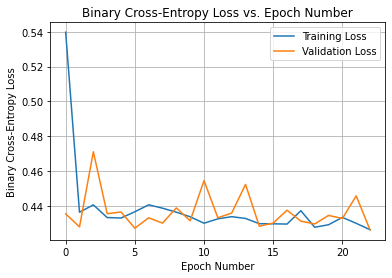

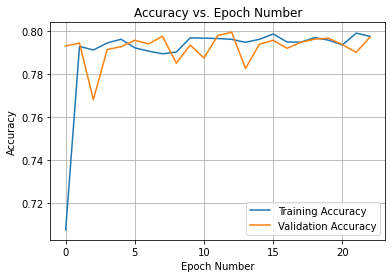

In [36]:
plotHistory(best_history)

In [37]:
acc, f1, p, r, cm, cr = evaluate(best_model, X_train, y_train)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[7303 2077]
 [1685 7718]]
Accuracy: 0.7997125059894585, Precision: 0.7879530372639102, Recall: 0.8208018717430607, F1-score: 0.8040420877174707
Classification Report:
              precision    recall  f1-score   support

     red win       0.81      0.78      0.80      9380
    blue win       0.79      0.82      0.80      9403

    accuracy                           0.80     18783
   macro avg       0.80      0.80      0.80     18783
weighted avg       0.80      0.80      0.80     18783



In [38]:
acc, f1, p, r, cm, cr = evaluate(best_model, X_val, y_val)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[2090  620]
 [ 457 2200]]
Accuracy: 0.7993292342090553, Precision: 0.7801418439716312, Recall: 0.8280015054572827, F1-score: 0.8033595033777615
Classification Report:
              precision    recall  f1-score   support

     red win       0.82      0.77      0.80      2710
    blue win       0.78      0.83      0.80      2657

    accuracy                           0.80      5367
   macro avg       0.80      0.80      0.80      5367
weighted avg       0.80      0.80      0.80      5367



In [39]:
acc, f1, p, r, cm, cr = evaluate(best_model, X_test, y_test)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[1028  294]
 [ 243 1119]]
Accuracy: 0.7999254843517138, Precision: 0.7919320594479831, Recall: 0.8215859030837004, F1-score: 0.8064864864864865
Classification Report:
              precision    recall  f1-score   support

     red win       0.81      0.78      0.79      1322
    blue win       0.79      0.82      0.81      1362

    accuracy                           0.80      2684
   macro avg       0.80      0.80      0.80      2684
weighted avg       0.80      0.80      0.80      2684



DESCRIPTION OF RESULTS

---
## **Task 3: Hyperparameter Selection/Regularization/Optimization of Gradient Descent**

In this section, we describe how we selected the model hyperparameters, whether or not we used regularization and whether or not we used an optimization algorithm for gradient descent.

HYPERPARAMETER TUNING: Describe how you selected the hyperparameters. What was the rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use an optimization algorithm? Why or why not?

---
## **Task 4: Comparison to a Baseline Model**

In this section, we train a baseline model for League of Legends game result prediction, and compare the results of this model to the results of the two-layer neural network.


In [27]:
# Define a sklearn Extra-Trees Classifier (bagging) with 100 estimators
bagging = ExtraTreesClassifier(n_estimators=100)

In [28]:
# Fit bagging model over entire training dataset
bagging.fit(X_train, y_train)

ExtraTreesClassifier()

In [29]:
acc, p, r, f1, cm, cr = evaluate(bagging, X_train, y_train)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[9380    0]
 [   0 9403]]
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-score: 1.0
Classification Report:
              precision    recall  f1-score   support

     red win       1.00      1.00      1.00      9380
    blue win       1.00      1.00      1.00      9403

    accuracy                           1.00     18783
   macro avg       1.00      1.00      1.00     18783
weighted avg       1.00      1.00      1.00     18783



In [30]:
acc, p, r, f1, cm, cr = evaluate(bagging, X_val, y_val)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[2142  568]
 [ 505 2152]]
Accuracy: 0.8000745295323272, Precision: 0.8004463455458434, Recall: 0.7911764705882353, F1-score: 0.8099360180654874
Classification Report:
              precision    recall  f1-score   support

     red win       0.81      0.79      0.80      2710
    blue win       0.79      0.81      0.80      2657

    accuracy                           0.80      5367
   macro avg       0.80      0.80      0.80      5367
weighted avg       0.80      0.80      0.80      5367



In [31]:
acc, p, r, f1, cm, cr = evaluate(bagging, X_test, y_test)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[1064  258]
 [ 253 1109]]
Accuracy: 0.809612518628912, Precision: 0.8127519237816049, Recall: 0.811265544989027, F1-score: 0.8142437591776799
Classification Report:
              precision    recall  f1-score   support

     red win       0.81      0.80      0.81      1322
    blue win       0.81      0.81      0.81      1362

    accuracy                           0.81      2684
   macro avg       0.81      0.81      0.81      2684
weighted avg       0.81      0.81      0.81      2684



COMPARISON: Compare the results of both models (the Neural Network and the
baseline model). What are the reasons for one model performing better (or not) than the other? Explain.